In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import ncar_jobqueue
from dask.distributed import Client

### noGCB case 

In [5]:
file = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_PH.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [7]:
file = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_PH_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [8]:
ds['pH_noGCB'] = ds_tmp['PH_ALT_CO2']

### 2xGCB case

In [9]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_PH_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [10]:
ds['pH_2xGCB'] = ds_tmp['PH_ALT_CO2']

In [11]:
ds

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
    PH        (nlat, nlon) float32 ...
    pH_noGCB  (nlat, nlon) float32 ...
    pH_2xGCB  (nlat, nlon) float32 ...

### Define a few plotting functions

In [12]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### Define plotting coords with WOA on POP grid
#### (doesn't have the nans in the coords)

In [15]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [16]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [17]:
depths.values[55]

4375.392513

In [18]:
nogcb_diff = ds.pH_noGCB - ds.PH

In [19]:
x2gcb_diff = ds.pH_2xGCB - ds.PH

In [21]:
x2gcb_diff

<xarray.DataArray (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.00311279, 0.00312042, 0.00310898, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface pH, Alternative CO2
    units:         1
    grid_loc:      2110
    cell_methods:  time: mean
    coordinates:   TLONG TLAT

#### Plot surface ph diff

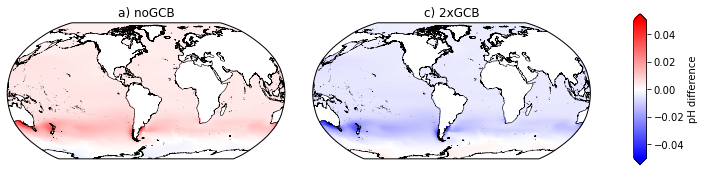

In [24]:
fig = plt.figure(figsize=(12,3))

######### DIC diff at surface layer for noGCB
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, nogcb_diff, vmin=-0.05, vmax=0.05, cmap='bwr',transform=ccrs.PlateCarree())


######### DIC diff at 200 m
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, x2gcb_diff, vmin=-0.05, vmax=0.05,cmap='bwr',transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='pH difference',extend='both')

In [31]:
lines = [-0.05,-0.045,-0.04,-0.035,-0.03,-0.025,-0.02,-0.015,-0.01,-0.005,0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]

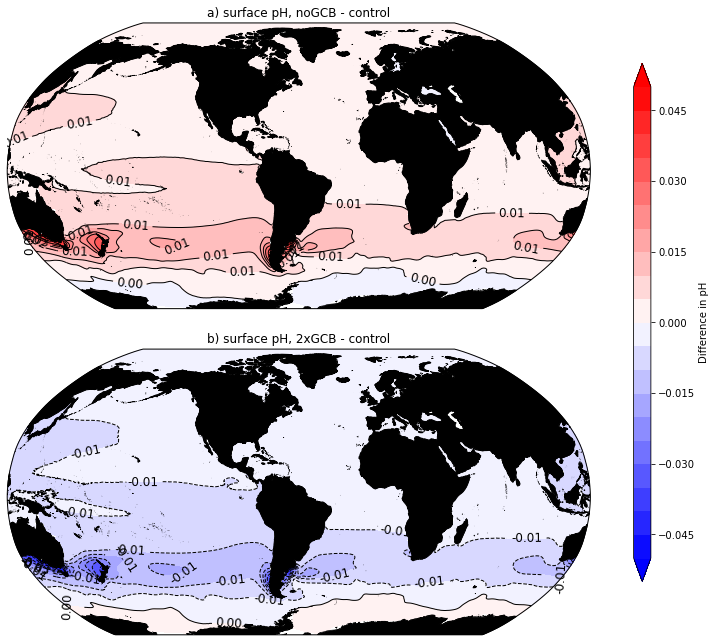

In [32]:
fig = plt.figure(figsize=(12,12))
contour_specs = {'levels': lines}

######### Difference in CO2 air-sea flux with NOCALC run
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,nogcb_diff)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('a) surface pH, noGCB - control')

#overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.2f', fontsize=12)

######### Difference in CO2 air-sea flux with 2xCALC run
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,x2gcb_diff)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('b) surface pH, 2xGCB - control')

##overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.2f', fontsize=12)

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.21, 0.02, 0.6])
cbar = fig.colorbar(cf, cax=cbar_ax,label='Difference in pH',extend='max')


#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/ph_diffs.pdf', bbox_inches='tight', format='pdf');
